In [153]:
%matplotlib inline
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from astropy.cosmology import Planck15 as cosmo
from astropy.table import Table
# from archivalCGMtools.loc4 import slime
#from goodies import closest
from mpl_toolkits import mplot3d
from astropy import stats as astats
%matplotlib inline
import pickle

from pyslime import slime
from pyslime import utils as psu

from scipy import stats

from pyslime.pipeline import interpolate, catalogs

pipedatadir = "/Users/mwilde/python/pyslime/pyslime/pipeline/data/"

In [154]:
mapping_data_pickle_file = "/Users/mwilde/python/pyslime/pyslime/pipeline/data/mapping_BP_z0p0_1sigma.pick"
smpackage = pickle.load(open(mapping_data_pickle_file,'rb'))

In [155]:
smpackage['bpdistribs_sm'], smpackage['smdistribs_sm']

([array([], dtype=float64),
  array([-0.66769776, -0.91698422, -0.87731425, ..., -0.7923029 ,
         -0.79102767, -0.95000591]),
  array([-1.06192154, -0.98008106, -0.88588297, ..., -0.77296833,
         -0.8231485 , -0.88030642]),
  array([-0.67846405, -0.64080825, -1.3200795 , ..., -0.7253995 ,
         -0.46703758, -1.24033479]),
  array([-0.93563409, -1.02447781, -1.15619928, ..., -1.09329668,
         -0.77453202, -0.57473729]),
  array([-1.00094571, -1.21479698, -0.8804768 , ..., -1.11767908,
         -0.6029126 , -0.63830605]),
  array([-0.7395247 , -1.17216184, -0.83074118, ..., -0.54422589,
         -1.05249304, -1.2448997 ]),
  array([-1.03534283, -1.20517503, -0.78939012, ..., -1.1627769 ,
         -1.20884689, -1.25642443]),
  array([-0.83365624, -0.86031488, -0.6587007 , ..., -1.05670266,
         -0.50018769, -0.68990547]),
  array([-0.85116006, -0.64583525, -0.99810618, ..., -0.65175217,
         -0.92098099, -1.3089383 ]),
  array([-1.06425492, -0.928248  , -0.9879710

In [156]:
err_lo = smpackage['loperc_bp']
err_hi = smpackage['hiperc_bp']
smpackage.keys()

dict_keys(['medvals_bp', 'meanvals_bp', 'loperc_bp', 'hiperc_bp', 'bpdistribs_sm', 'smdistribs_sm', 'smrhobins'])

In [157]:
smrhobins = smpackage['smrhobins']
binsize = 0.1
midbins = 0.5*smrhobins[:-1]+ 0.5*smrhobins[1:]

# The first and last bins have 0 counts, don't include them

In [158]:
nonan = ~np.isnan(smpackage['medvals_bp'])

In [159]:
from scipy.interpolate import InterpolatedUnivariateSpline

mapfunc = InterpolatedUnivariateSpline(midbins[nonan], smpackage['medvals_bp'][nonan], k=1)

In [160]:
from scipy.interpolate import interp1d
mapfunc1d = interp1d(midbins[nonan], smpackage['medvals_bp'][nonan])

In [161]:
mapfunc1d


In [162]:
smdens, bpdens = midbins[nonan], smpackage['medvals_bp'][nonan]
err_lo = smpackage['loperc_bp'][nonan]
err_hi = smpackage['hiperc_bp'][nonan]

In [163]:
def find_xbreak(smdens, bpdens, plot=False):
    break_cut = (smdens > 0) & (smdens < 2)
    xmiddiff = 0.5*smdens[break_cut][1:] + 0.5*smdens[break_cut][:-1]
    diff = np.diff(bpdens[break_cut])
    xbreak = xmiddiff[np.argmax(diff)]
    if plot:
        plt.plot(xmiddiff, diff)
        plt.axvline(xbreak)
    return xbreak
    


In [164]:
smdens, bpdens = midbins[nonan], smpackage['medvals_bp'][nonan]


def find_xbreak(smdens, bpdens, plot=False):
    break_cut = (smdens > 0) & (smdens < 2)
    xmiddiff = 0.5*smdens[break_cut][1:] + 0.5*smdens[break_cut][:-1]
    diff = np.diff(bpdens[break_cut])
    xbreak = xmiddiff[np.argmax(diff)]
    if plot:
        plt.plot(xmiddiff, diff)
        plt.axvline(xbreak)
    return xbreak

# find where the break is
x = np.linspace(0, 2)
xbreak = find_xbreak(smdens, bpdens)
print(xbreak)

# find what the constant y value below this break is
y_const = np.mean(bpdens[smdens < xbreak])
print(y_const)

# constrain where to do the linear fitting
lin_cut = (smdens > xbreak-0.5)

# 
xfit = smdens[lin_cut]
yfit = bpdens[lin_cut]
slope, intercept, r_value, p_value, std_err = stats.linregress(xfit, yfit)
z = np.polyfit(xfit, yfit, 3)
pfit = np.poly1d(z)






def linmap(smdens, xbreak, y_const, slope, intercept):
    y_lin = slope * smdens + intercept
    y = np.where(smdens < xbreak, y_const, y_lin)
    
    return y

def rectified(x, y_const):
    y = slope * x + intercept
    return np.maximum(y_const, y)

def rectifiedp3(x):
    y_const = np.mean(bpdens[smdens < xbreak])
    xfit = smdens[lin_cut]
    yfit = bpdens[lin_cut]
    z = np.polyfit(xfit, yfit, 3)
    pfit = np.poly1d(z)

    y = np.where(x < xbreak-0.3, y_const, pfit(x))
    return np.maximum(y_const, y)

        

1.800886893272403
-0.7178550500445366


In [165]:
z, xbreak, y_const

(array([-0.14801735,  1.30697963, -2.16118108,  0.59161293]),
 1.800886893272403,
 -0.7178550500445366)

In [166]:
mapfunck5 = InterpolatedUnivariateSpline(midbins[nonan], smpackage['medvals_bp'][nonan], k=1)

import scipy
spline = scipy.interpolate.UnivariateSpline(midbins[nonan], smpackage['medvals_bp'][nonan], k=1, s=0.000001)

In [167]:
spline

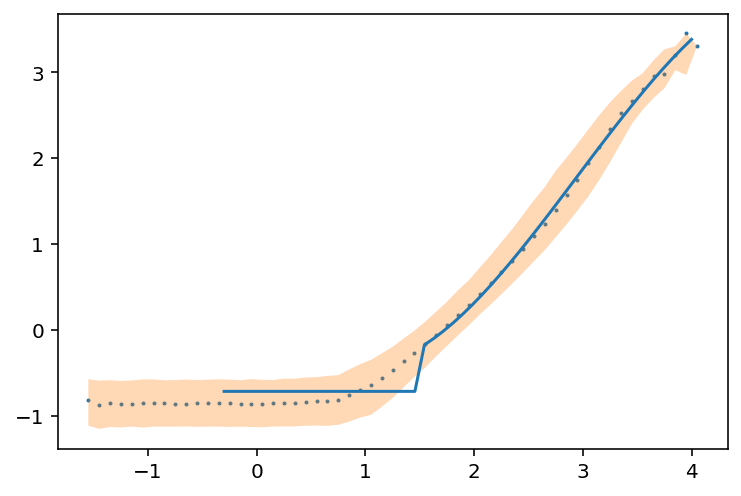

In [168]:
from scipy import stats

xfull = np.linspace(-0.3, 4, 50)
plt.scatter(smdens, bpdens, s=1)
plt.fill_between(smdens, y1=err_lo, y2=err_hi, alpha=0.3)
# plt.plot(xfull, mapfunck5(xfull), label='spline')

# plt.plot(xfull, mapfunc(xfull), label='spline')
# plt.plot(xfull, spline(xfull))
# plt.plot(xfit, pfit(xfit))
# plt.plot(xfull, mapfunc1d(xfull), label='interp1d')
# plt.plot(xfull, linmap(xfull, xbreak, y_const, slope, intercept), label='lin');
# plt.plot(xfull, rectified(xfull, y_const), label='lin');
plt.plot(xfull, rectifiedp3(xfull), label='lin');
# plt.plot(midbins, terpSlimeBp(midbins), label='interp')
# plt.scatter(midbins, smpackage['medvals_bp'])

In [111]:
# check that this mapping gets something reasonable for a coma like density
# this number comes from the standardize_sdss notebook/rerouting-to-data notebook
3.96
mapfunc(3.6)

array(2.88167819)

# test on a gaussian

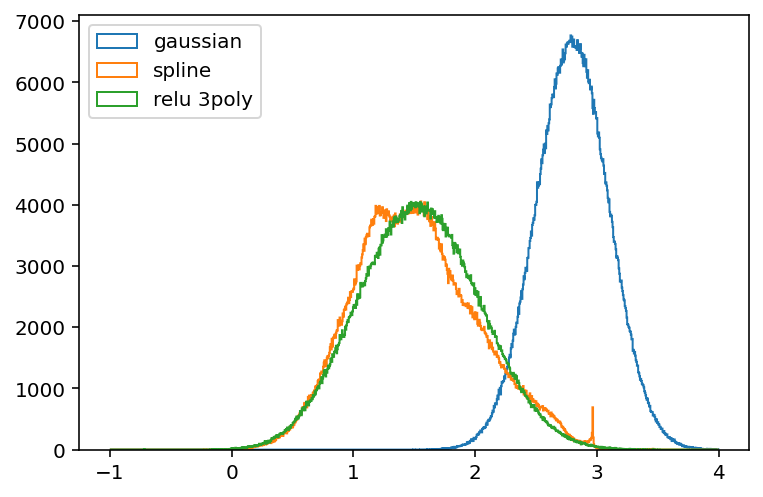

In [112]:
g = np.random.normal(2.8, 0.3, 1000000)

bins = np.linspace(-1,4, 1000)
kwargs = {}
kwargs['bins'] = bins
kwargs['histtype'] = 'step'

spline = scipy.interpolate.UnivariateSpline(midbins[nonan], smpackage['medvals_bp'][nonan], k=5, s=1e-9)

plt.hist(g, **kwargs, label='gaussian');
plt.hist(spline(g), **kwargs, label='spline');
plt.hist(rectifiedp3(g), **kwargs, label='relu 3poly')
plt.legend(loc='upper left')

plt.show()

# below, I am investigating using linear fit but the above mapping seams to work well. 

In [134]:
mapping_data_pickle_file = "/Users/mwilde/python/pyslime/pyslime/pipeline/data/mapping_BP_z0p0_1sigma.pick"
smpackage = pickle.load(open(mapping_data_pickle_file,'rb'))
smdens, bpdens = interpolate.slurp_data(mapping_data_pickle_file)

# constrain where to do the fitting: only past the break
xbreak = find_xbreak(smdens, bpdens)
lin_cut = smdens > xbreak - 0.5

xfit = smdens[lin_cut]
yfit = bpdens[lin_cut]

err_lo = smpackage['loperc_bp'][nonan]
err_hi = smpackage['hiperc_bp'][nonan]

xbreak = interpolate.find_xbreak(smdens, bpdens)
y_const = interpolate.find_y_const(smdens, bpdens, xbreak)
lin_cut = smdens > 0.8 - 0.5
xfit = smdens[lin_cut]
yfit = bpdens[lin_cut]

z = np.polyfit(xfit, yfit, 3)
pfit = np.poly1d(z)

outdict = {}
outdict["xbreak"] = xbreak
outdict["y_const"] = y_const
outdict["pfit"] = pfit

mapfunc = interpolate.relu_p3(x, xbreak, y_const, pfit)

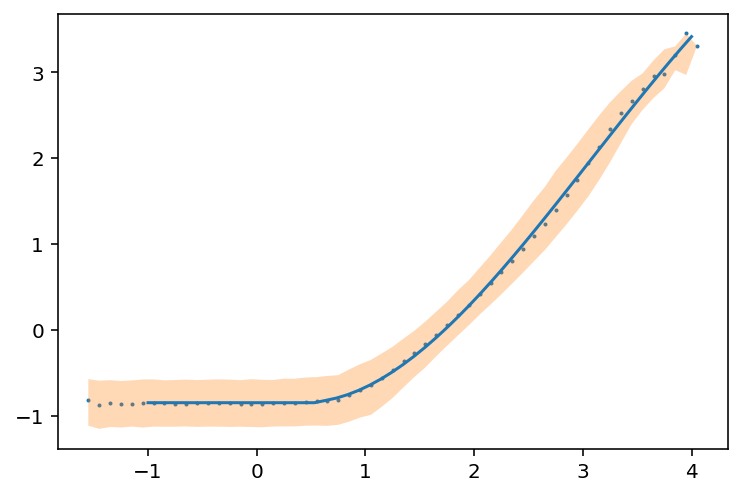

In [137]:
xfull = np.linspace(-1, 4, 50)
plt.scatter(smdens, bpdens, s=1)
plt.fill_between(smdens, y1=err_lo, y2=err_hi, alpha=0.3)
# plt.plot(xfull, mapfunck5(xfull), label='spline')

# plt.plot(xfull, mapfunc(xfull), label='spline')
# plt.plot(xfull, spline(xfull))
plt.plot(xfull, interpolate.relu_p3(xfull, 0.85, -0.85, pfit))
# plt.plot(xfull, mapfunc1d(xfull), label='interp1d')
# plt.plot(xfull, linmap(xfull, xbreak, y_const, slope, intercept), label='lin');#

In [130]:
xbreak0, y_const0, pfit0, xbreak5, y_const5, pfit5 = catalogs.load_mapfuncs(pipedatadir)

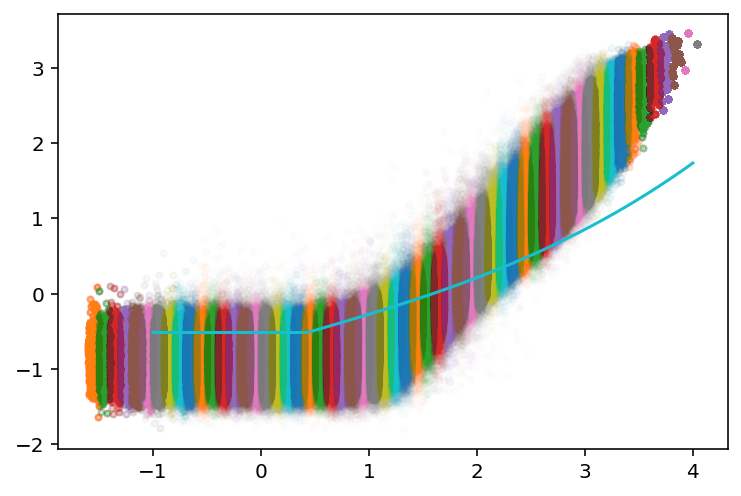

In [131]:
bpdistribs_sm = smpackage['bpdistribs_sm']
smdistribs_sm = smpackage['smdistribs_sm']

g = np.random.normal(2.8, 0.3, 1000000)
for i in range(len(smdistribs_sm)):
    plt.plot(smdistribs_sm[i], bpdistribs_sm[i],'.',alpha=0.01)

plt.plot(xfull, interpolate.relu_p3(xfull, xbreak5, y_const5, pfit5))

In [120]:
np.ravel(bpdistribs_sm[1:-1])

array([ 0.13150132, -0.05489456, -0.70870872, ...,  1.42808501,
        1.97636692,  1.42808501])

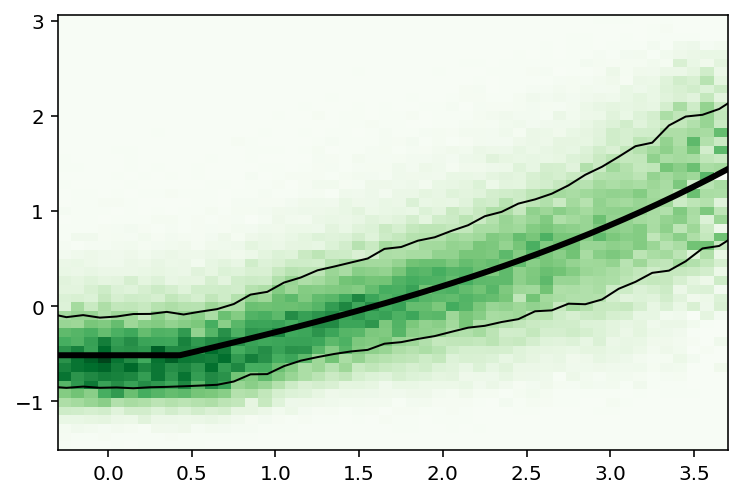

In [121]:
g = np.random.normal(2.8, 0.3, 1000000)
smdata = np.array(smdistribs_sm[1:-5]).flatten()
bpdata = np.array(bpdistribs_sm[1:-5]).flatten()
import cmasher
cmap = cmasher.nuclear
cut = smdata > -0.3
plt.hist2d(smdata[cut], bpdata[cut], bins=(50, 50), cmap='Greens')

plt.plot(xfull, interpolate.relu_p3(xfull, xbreak5, y_const5, pfit5), c='k', lw=3)
err_lo = smpackage['loperc_bp'][nonan]
err_hi = smpackage['hiperc_bp'][nonan]
plt.plot(smdens[1:-1], err_lo[1:-1], c='k', lw=1)
plt.plot(smdens[1:-1], err_hi[1:-1], c='k', lw=1)

In [122]:
smlst = []
for smbin in smdistribs_sm[1:-1]:
    smlst.append(np.ravel(smbin))

In [123]:
smdata = np.array(smdistribs_sm[1:-1]).flatten()
bpdata = np.array(bpdistribs_sm[1:-1]).flatten()

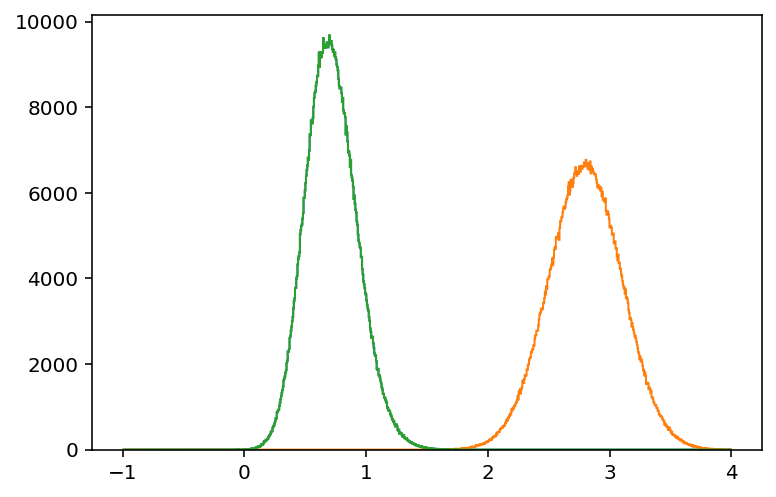

In [124]:

g = np.random.normal(2.8, 0.3, 1000000)
plt.hist(interpolate.relu_p3(g, xbreak5, y_const5, pfit5), **kwargs)
plt.hist(g, **kwargs);
plt.hist(interpolate.relu_p3(g, xbreak, y_const, pfit), **kwargs);

In [125]:
mapfunc(3.53)

TypeError: 'numpy.ndarray' object is not callable

In [126]:
mapfunc(3.4574211329533497)

TypeError: 'numpy.ndarray' object is not callable

In [127]:
10**2.67838699

476.85571289667365